# **StockTrendSVM: Enhanced Stock Direction Predictor**
This application implements a classical Support Vector Machine (SVM) model to predict stock price direction, augmented with sentiment features derived from financial news headlines using a transformer-based model. Compatible with Google Colab.

Install libraries:

In [4]:
# Install required packages
!pip install yfinance fredapi nltk transformers datasets --quiet

In [5]:
# Import libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from fredapi import Fred
import nltk
nltk.download('vader_lexicon')

# Hugging Face transformer imports
from transformers import pipeline

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


Define API keys and download stock data:

In [6]:
# Define API keys (required for FRED)
FRED_API_KEY = 'your_fred_api_key_here'  # Replace with your own API key
fred = Fred(api_key=FRED_API_KEY)

# Download stock data
ticker = 'AAPL'
stock_data = yf.download(ticker, start='2020-01-01', end='2024-01-01')

# Flatten MultiIndex columns if present (common with yfinance data)
if isinstance(stock_data.columns, pd.MultiIndex):
    stock_data.columns = ['_'.join(filter(None, col)).strip() for col in stock_data.columns.values]

# Rename columns for easier use
rename_map = {f'Close_{ticker}': 'Close', f'Volume_{ticker}': 'Volume'}
stock_data.rename(columns=rename_map, inplace=True)

/tmp/ipython-input-2219576738.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(ticker, start='2020-01-01', end='2024-01-01')
ERROR:yfinance:Failed to get ticker 'AAPL' reason: Failed to perform, curl: (28) Connection timed out after 10002 milliseconds. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.
[*********************100%***********************]  1 of 1 completed


Feature engineering:

In [7]:
# Feature engineering – technical indicators
stock_data['MA10'] = stock_data['Close'].rolling(window=10).mean()
stock_data['MA50'] = stock_data['Close'].rolling(window=50).mean()
stock_data['Return'] = stock_data['Close'].pct_change()
stock_data['Volatility'] = stock_data['Return'].rolling(window=10).std()

Add macroeconomic indicator:

In [8]:
# Add macroeconomic indicator (10-Year Treasury Rate)
try:
    interest_rate = fred.get_series('GS10')  # Monthly data
    interest_rate = interest_rate.resample('D').ffill()  # Forward fill daily
    interest_rate.name = 'InterestRate'
    interest_rate = interest_rate.to_frame()
    stock_data = stock_data.reset_index()  # Make Date a column for merging
    stock_data = stock_data.merge(interest_rate, how='left', left_on='Date', right_index=True)
    stock_data['InterestRate'].fillna(method='ffill', inplace=True)
except Exception as e:
    print("FRED API not connected or failed to retrieve macro data.")
    stock_data['InterestRate'] = 0  # fallback

/tmp/ipython-input-2747558157.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  stock_data['InterestRate'].fillna(method='ffill', inplace=True)
/tmp/ipython-input-2747558157.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock_data['InterestRate'].fillna(method='ffill', inplace=True)


Prepare transformer sentiment analysis pipeline:

In [9]:
# Prepare transformer sentiment analysis pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu


Prepare financial news headlines:

In [10]:
# Example financial news headlines mapped by date
news_data = {
    '2023-11-20': "Apple reports record revenue driven by strong iPhone sales.",
    '2023-11-21': "Supply chain disruptions impact Apple’s quarterly performance.",
    '2023-11-22': "Analysts optimistic about Apple's new product launches.",
    '2023-11-23': "Apple faces lawsuit over app store policies.",
    '2023-11-24': "Strong holiday season expected to boost Apple sales.",
    # Extend or replace with real daily headlines for better accuracy
}

news_df = pd.DataFrame(list(news_data.items()), columns=['Date', 'Headline'])
news_df['Date'] = pd.to_datetime(news_df['Date'])

Prepare sentiment scores for financial news headlines:

In [11]:
# Compute sentiment scores for headlines
def compute_sentiment(text):
    result = sentiment_pipeline(text)[0]
    score = result['score']
    return score if result['label'] == 'POSITIVE' else -score

news_df['SentimentScore'] = news_df['Headline'].apply(compute_sentiment)

In [12]:
# Merge sentiment scores into stock_data by 'Date'
stock_data = stock_data.merge(news_df[['Date', 'SentimentScore']], on='Date', how='left')

# Fill missing sentiment scores with forward fill, then zero
stock_data['SentimentScore'] = stock_data['SentimentScore'].fillna(method='ffill').fillna(0)

/tmp/ipython-input-2112497074.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock_data['SentimentScore'] = stock_data['SentimentScore'].fillna(method='ffill').fillna(0)


Define target variable (next day price movement):

In [13]:
# Define target variable (next day price movement)
stock_data['Target'] = (stock_data['Return'].shift(-1) > 0).astype(int)

# Clean dataset (drop NaNs)
stock_data = stock_data.dropna()

Prepare feature matrix and target vector:

In [14]:
# Prepare feature matrix and target vector
features = ['MA10', 'MA50', 'Volatility', 'Volume', 'InterestRate', 'SentimentScore']
X = stock_data[features]
y = stock_data['Target']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into train and test sets (no shuffle for time series)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

# Train SVM classifier
clf = SVC(kernel='rbf', C=1.0, gamma='auto')
clf.fit(X_train, y_train)

SVC(gamma='auto')

Make predictions and evaluate model:

In [15]:
# Make predictions and evaluate model
y_pred = clf.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print('Accuracy:', accuracy_score(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.45      0.83      0.58        88
           1       0.46      0.12      0.20       104

    accuracy                           0.45       192
   macro avg       0.45      0.48      0.39       192
weighted avg       0.46      0.45      0.37       192

Accuracy: 0.4479166666666667


Visualise actual vs predicted price movement:

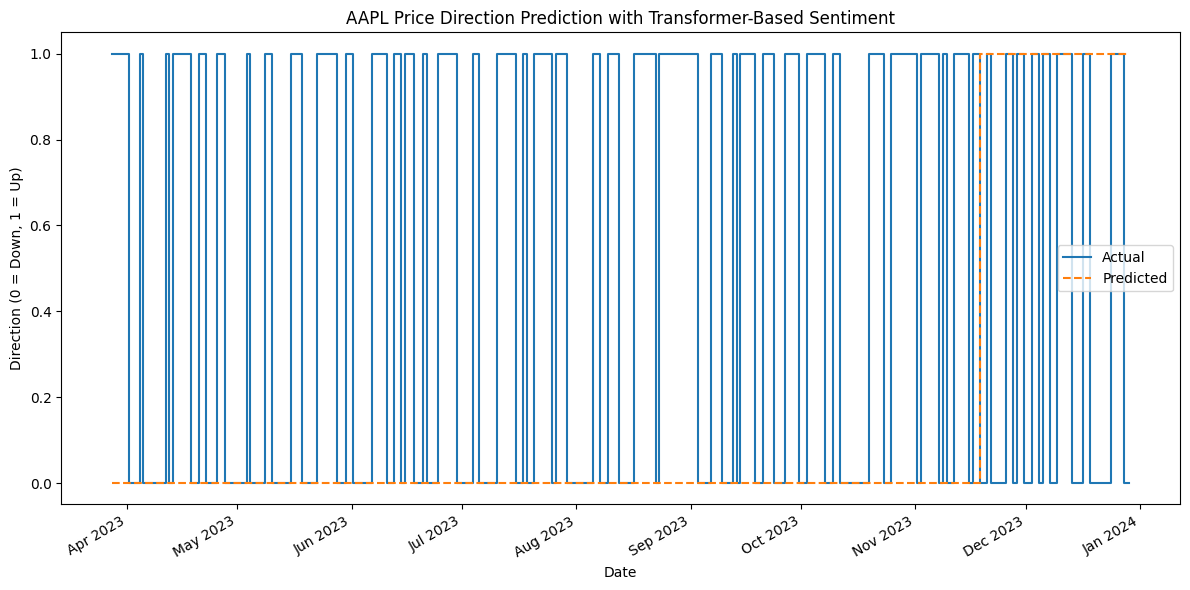

In [20]:
# Visualise actual vs predicted price movement
plt.figure(figsize=(12, 6))
plt.step(stock_data['Date'].iloc[-len(y_test):], y_test.values, label='Actual', where='mid')
plt.step(stock_data['Date'].iloc[-len(y_test):], y_pred, label='Predicted', where='mid', linestyle='--')

# Use monthly ticks
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Every month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Format as "Jan 2023"
plt.gcf().autofmt_xdate()

plt.title(f'{ticker} Price Direction Prediction with Transformer-Based Sentiment')
plt.ylabel('Direction (0 = Down, 1 = Up)')
plt.xlabel('Date')
plt.legend()
plt.tight_layout()
plt.show()